In [2]:
import scanpy as sc
import numpy as np
import sctm
import squidpy as sq

%load_ext autoreload
%autoreload 2

/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In this tutorial, we demonstrate how to analyse multiple tissue slices in horizontal integration. Here we take mouse anterior and posterior brain as example. ST data were downloaded from https://www.10xgenomics.com/. Before inputting the model, alignment algorithm was implemented to align mouse anterior and posterior brain data.

The prepocessed data can be accessible and downloaded via https://drive.google.com/drive/folders/1jDmx8IjiGhOD__spuuhFB1fWVDJtv5CU.

In [3]:
adata = sc.read_h5ad("../../../../spatialLDA/spatiallda/reproducibility/figure1/data/Mouse_Brain_Merge_Anterior_Posterior_Section_2/filtered_feature_bc_matrix.h5ad")
adata.var_names_make_unique()

In [4]:
adata

AnnData object with n_obs × n_vars = 6114 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'data'
    obsm: 'spatial'

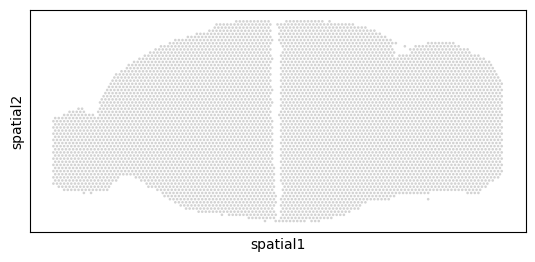

In [5]:
sc.pl.spatial(adata, spot_size = 100)

In [16]:
sc.pp.filter_cells(adata, min_genes=50)
sctm.pp.filter_genes(adata, 0.03,  expression_cutoff_99q = 1)
sc.pp.highly_variable_genes(adata, n_top_genes=8000, flavor="seurat_v3", batch_key = 'data')

In [17]:
sq.gr.spatial_neighbors(adata, library_key = "data")

In [18]:
n_topics = 30
# Only hvgs and fit a total of 30 topics
model = sctm.stamp.STAMP(
    adata[:, adata.var.highly_variable],
    n_topics = n_topics,
    beta =0.1,
    batch_key = 'data'
)

# uses gpu by default to use cpu use device="cpu"
model.train()

Computing background frequencies


tensor(41807852.)
Layer (type:depth-idx)                   Param #
OptimizedModule                          --
├─spatialLDAModel: 1-1                   --
│    └─MLPEncoderMVN: 2-1                --
│    │    └─Dropout: 3-1                 --
│    │    └─BatchNorm1d: 3-2             32,004
│    │    └─BatchNorm1d: 3-3             100
│    │    └─BatchNorm1d: 3-4             --
│    │    └─BatchNorm1d: 3-5             --
│    │    └─Linear: 3-6                  1,530
│    │    └─Linear: 3-7                  1,530
│    │    └─Linear: 3-8                  22,185
│    │    └─Linear: 3-9                  800,150
Total params: 857,499
Trainable params: 857,499
Non-trainable params: 0


Loss:7550.044:  21%|██▏       | 426/2000 [04:53<18:05,  1.45it/s]

Early Stopping


In [19]:
# Get topic prop which is the latent representation and beta which are the gene modules
topic_prop = model.get_cell_by_topic()
beta = model.get_feature_by_topic()
# Add it into adata to visualize
for i in topic_prop.columns:
    adata.obs[i] = topic_prop[i]

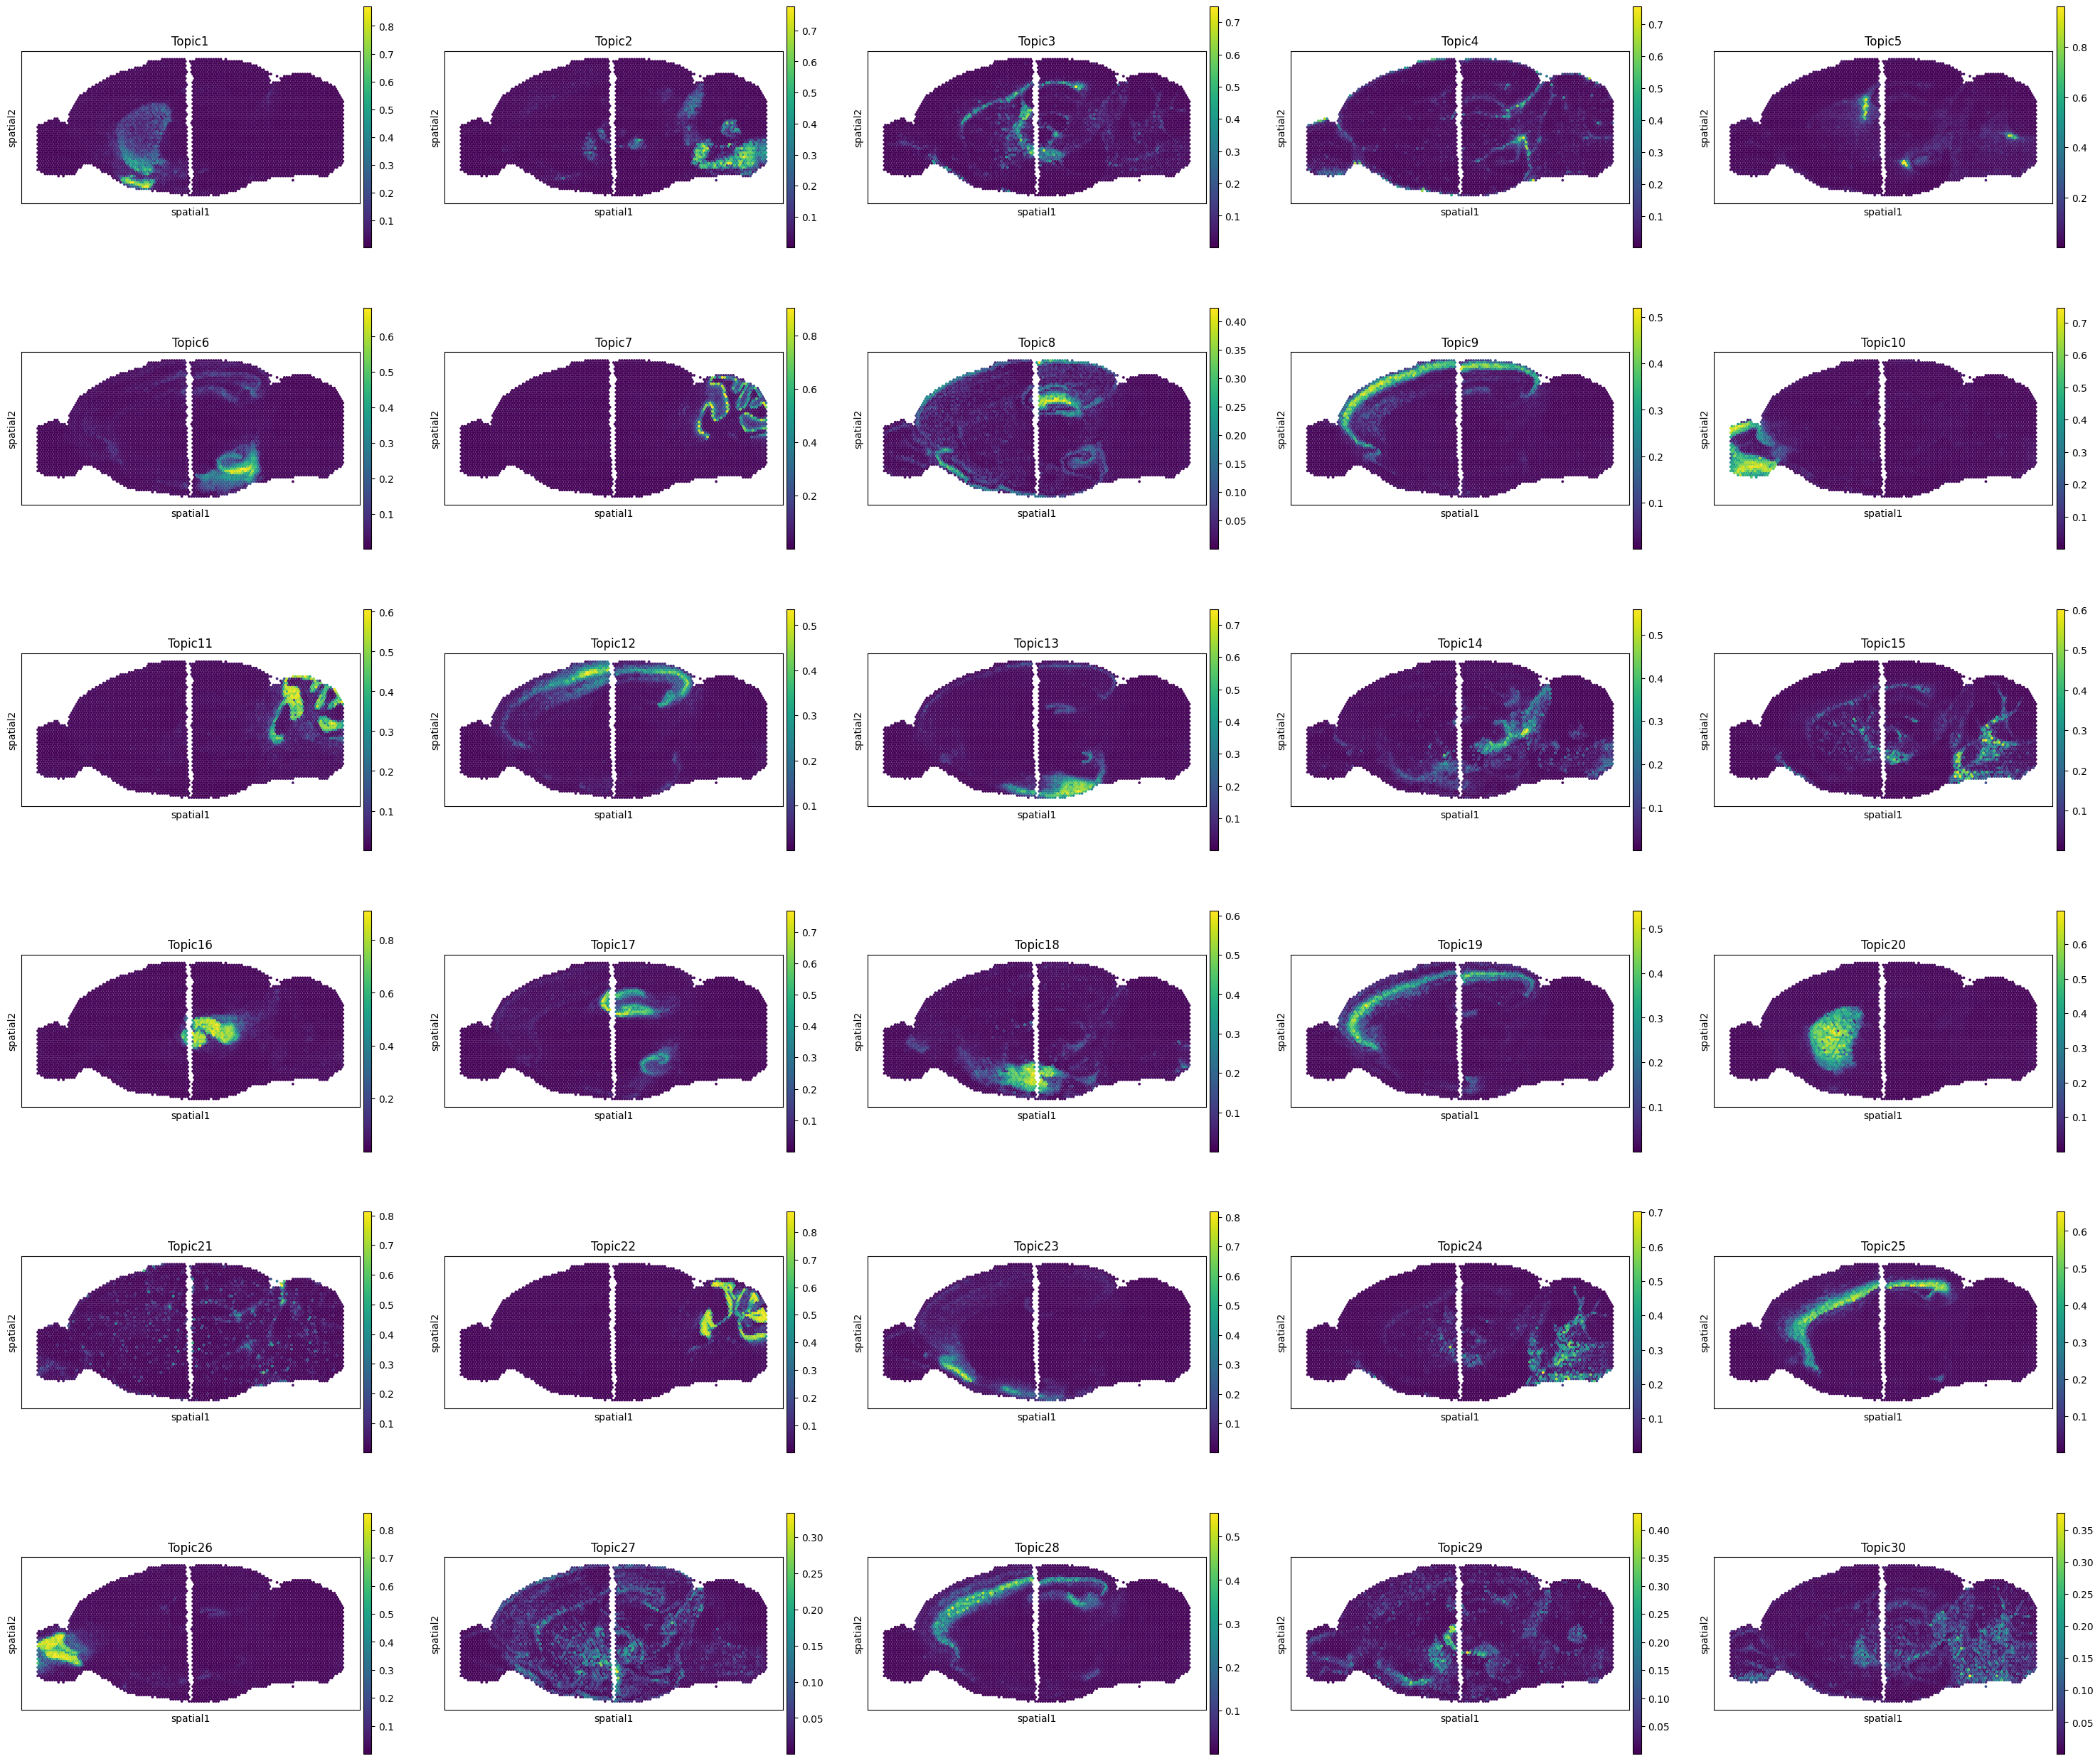

In [20]:
sc.pl.spatial(adata, color = topic_prop.columns, ncols = 5, spot_size = 150)

In [11]:
# Get topic prop which is the latent representation and beta which are the gene modules
topic_prop = model.get_cell_by_topic()
beta = model.get_feature_by_topic()
# Add it into adata to visualize
for i in topic_prop.columns:
    adata.obs[i] = topic_prop[i]

In [21]:
top_genes = []
for i in topic_prop.columns:
    top_genes += beta.nlargest(1, i).index.tolist()

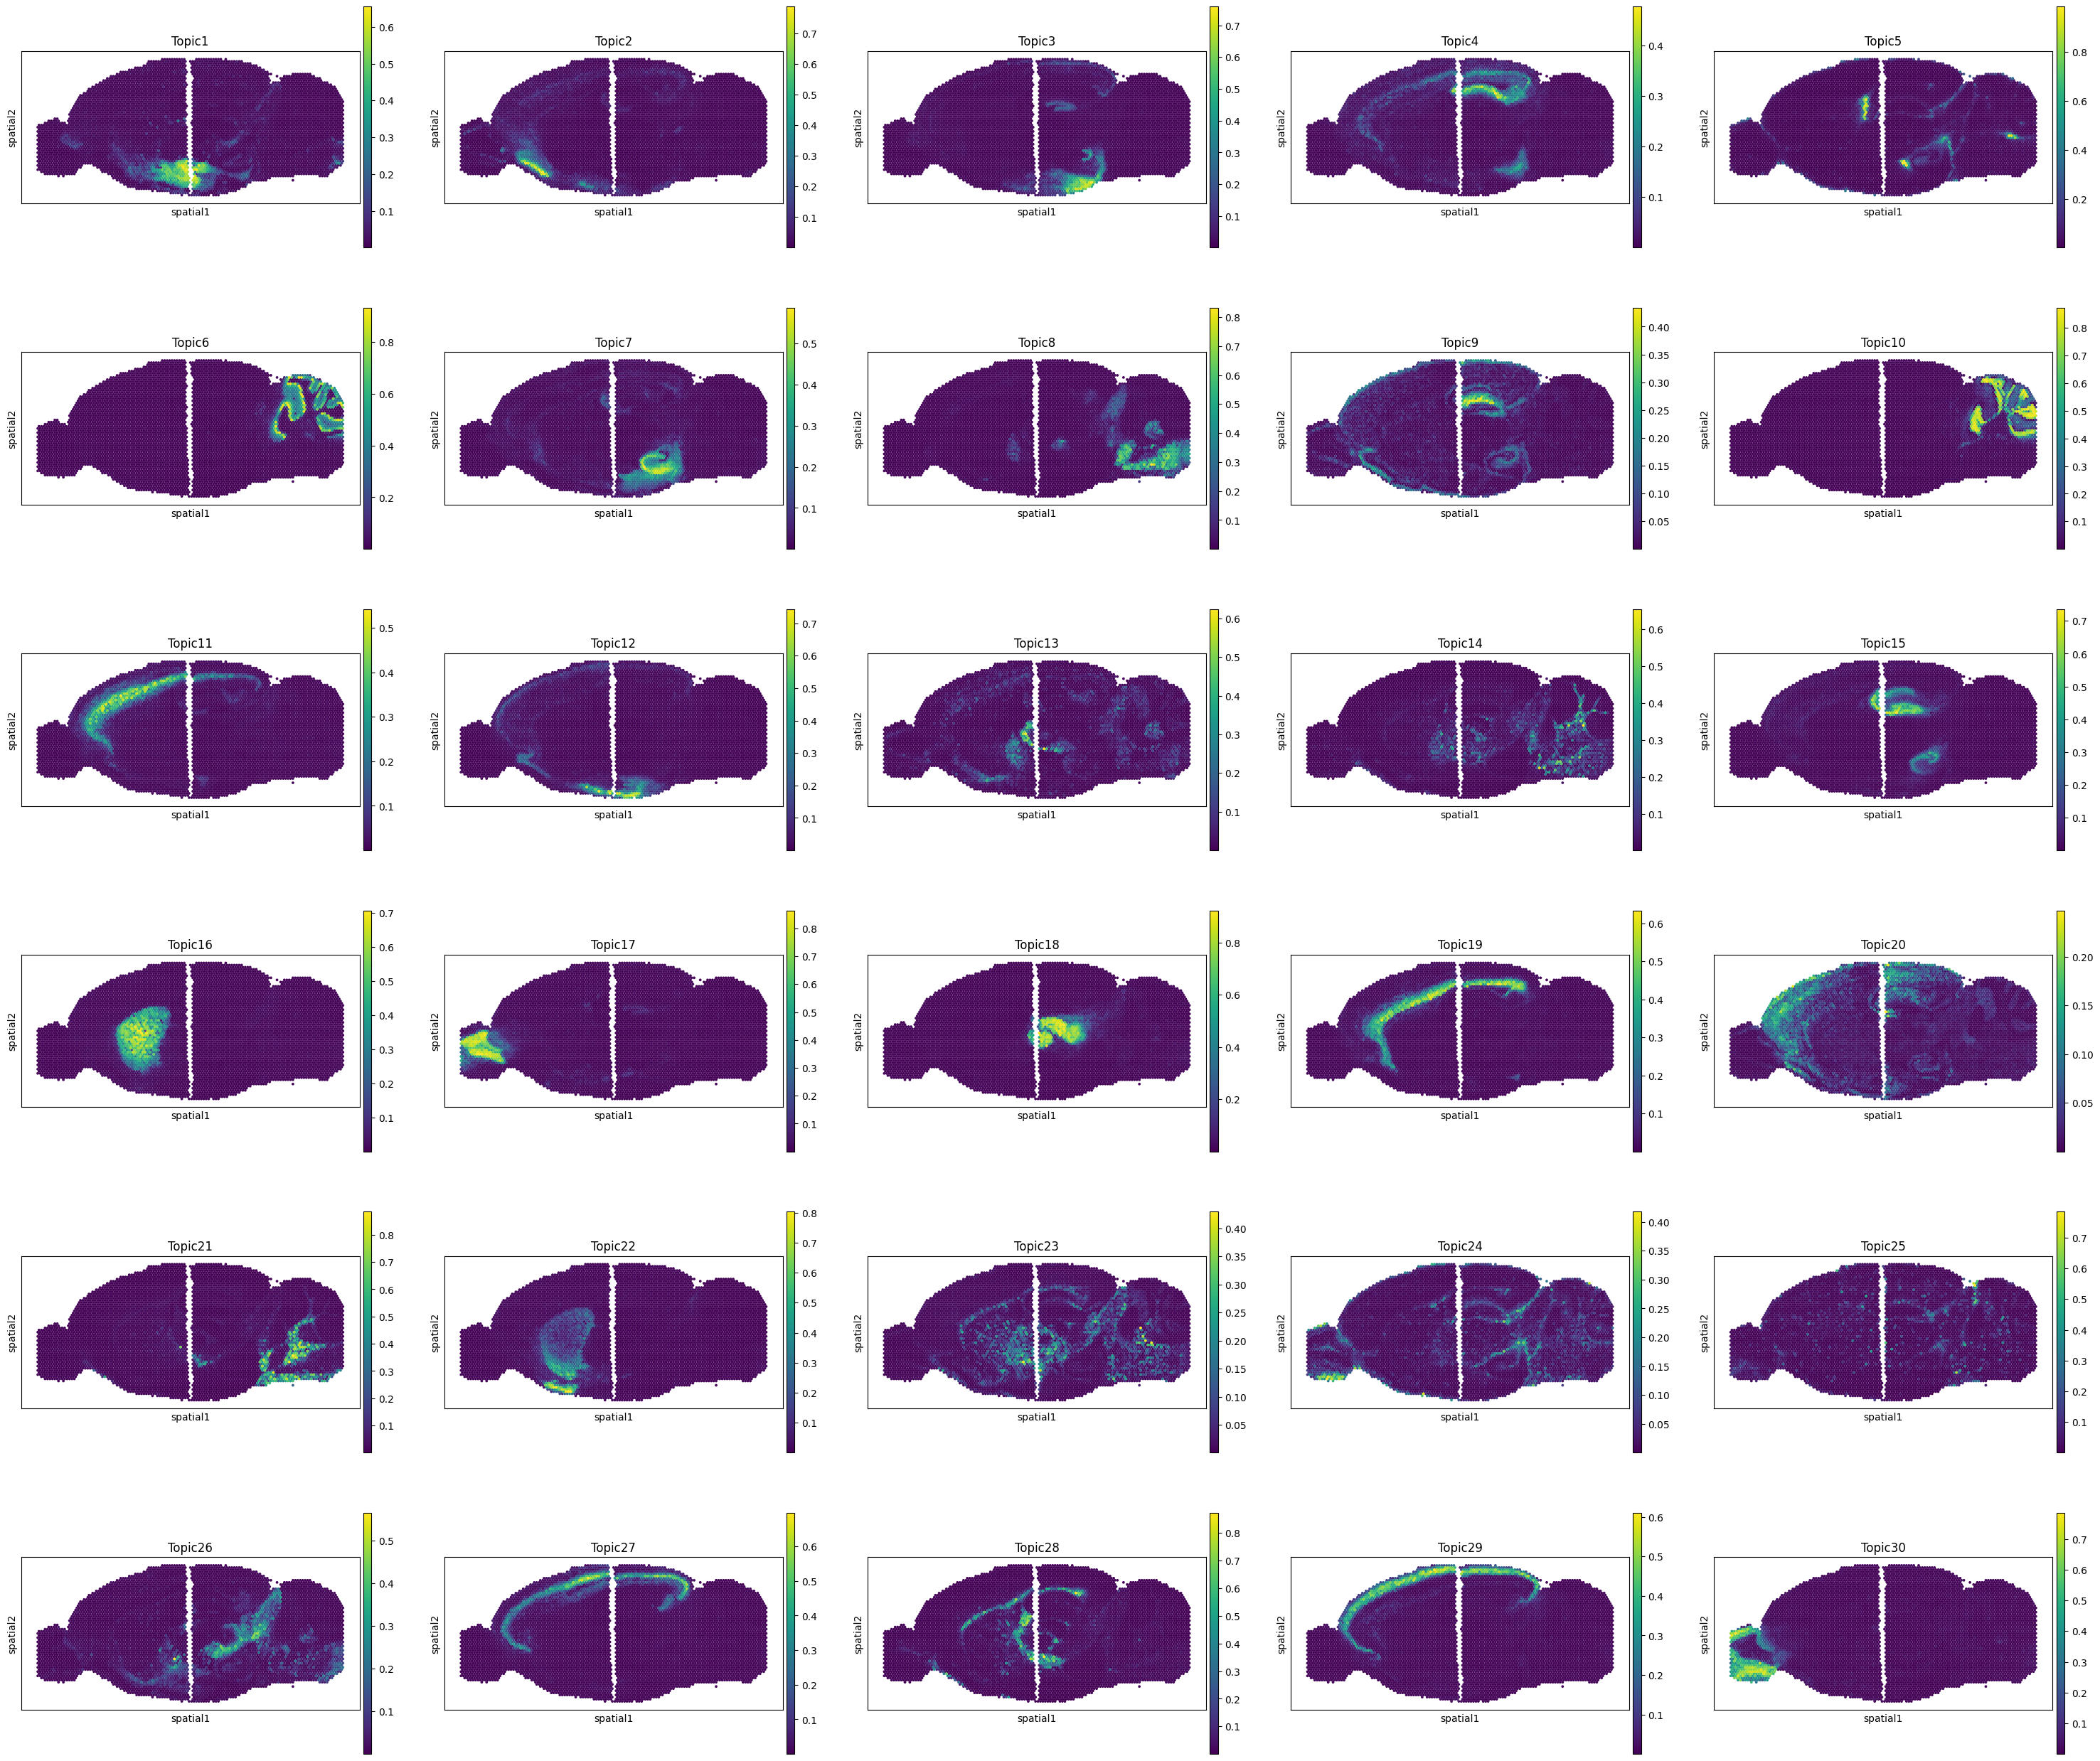

In [12]:
sc.pl.spatial(adata, color = top_genes, ncols = 5, spot_size = 150)